# Laser segmentation

In this article a method to detect the laser stripe and generate a vector of 2D points is presented.

In [1]:
%pylab inline
%matplotlib inline

import cv2
import datetime
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

_begin = 0
total_time = datetime.timedelta()

# Time measurement functions

def begin():
    global _begin
    _begin = datetime.datetime.now()
    
def end():
    global _begin, total_time
    end = datetime.datetime.now() - _begin
    total_time += end
    print('Time: %s' % end)

# Plot image functions

def plot_image(image):
    if len(image.shape) == 2:
        image = cv2.merge((image,image,image))
    f, axarr = plt.subplots(1, 1, figsize=(10,15))
    axarr.axis('off')
    axarr.imshow(image)
    axarr.plot()
    
def plot_images(images):
    f, axarr = plt.subplots(1, len(images), figsize=(15,15))
    for i in range(len(images)):
        if len(images[i].shape) == 2:
            image = cv2.merge((images[i],images[i],images[i]))
        else:
            image = images[i]
        axarr[i].axis('off')
        axarr[i].imshow(image)
        axarr[i].plot()

Populating the interactive namespace from numpy and matplotlib


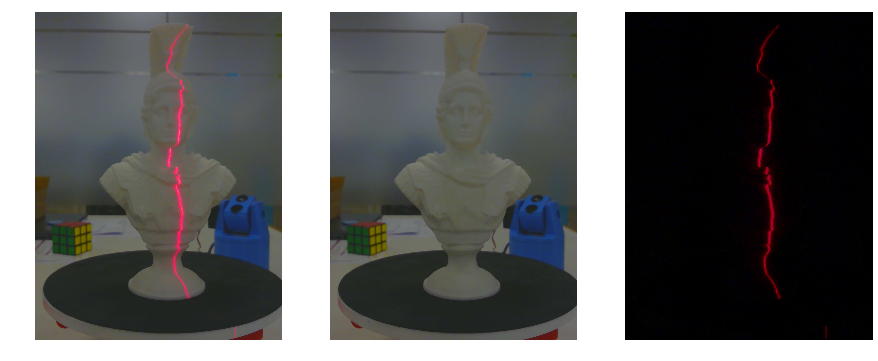

In [2]:
# Load images

def load_image(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = load_image('images/3. Laser segmentation/laser.png')
image_background = load_image('images/3. Laser segmentation/laser_background.png')

plot_images((image, image_background, cv2.subtract(image, image_background)))

## Monochromatic space

### R from RGB

Time: 0:00:00.001273


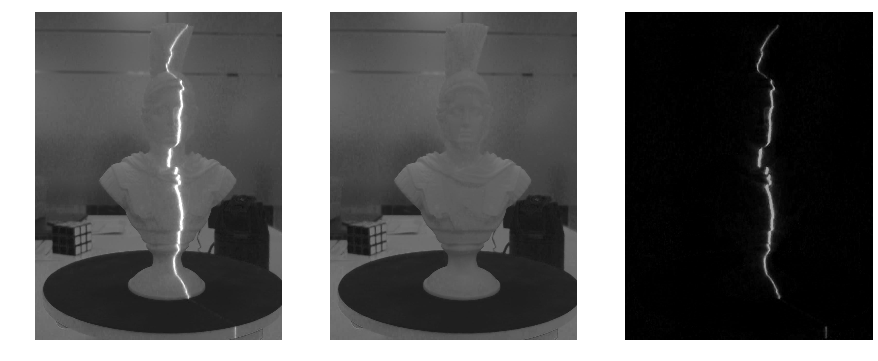

In [3]:
def r_rgb(image):
    return cv2.split(image)[0]

image_r = r_rgb(image)
image_background_r = r_rgb(image_background)

begin()

image_diff = cv2.subtract(image_r, image_background_r)
image_diff_r = r_rgb(image_diff)

end()

plot_images((image_r, image_background_r, image_diff_r))

## Threshold
It is used to filter near line noise and also background noise.

$$
dst(x, y) =
  \begin{cases}
    src(x,y)       & \quad \text{if } src(x,y) \: > \text{ threshold}\\
    0       & \quad \text{otherwise } \\
  \end{cases}
$$

Time: 0:00:00.006025


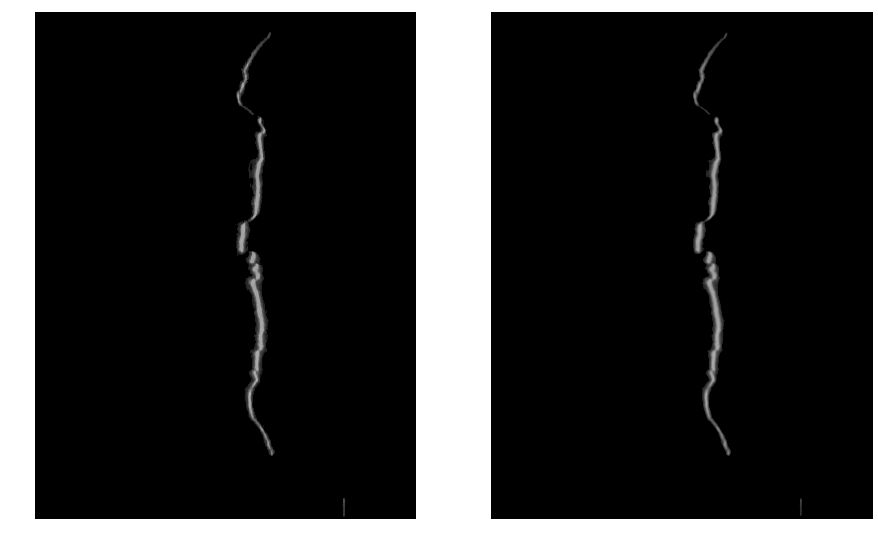

In [4]:
# Threshold image

begin()

threshold_value = 30
image_threshold = cv2.threshold(image_diff_r, threshold_value, 255, cv2.THRESH_TOZERO)[1]

# Blur image

blur_value = 5
image_blur = cv2.blur(image_threshold, (blur_value, blur_value))

image_blur_threshold = cv2.threshold(image_blur, threshold_value, 255, cv2.THRESH_TOZERO)[1]

end()

plot_images((image_threshold, image_blur_threshold))

## Valid window mask
It is computed for each row a window around the intensity peak value in order to apply a mask to the image to avoid possible speckles and background noise. This mask is applied to the original monochromatic image.

Time: 0:00:00.012022


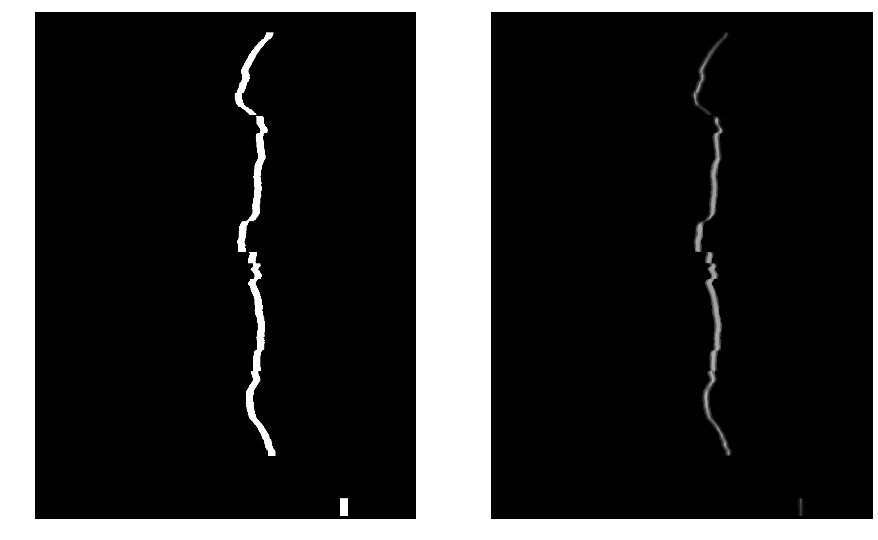

In [5]:
window = 9

begin()

peak = image_blur_threshold.argmax(axis=1)
_min = peak - window
_max = peak + window + 1
mask = np.zeros_like(image_blur_threshold)
for i in xrange(image_blur_threshold.shape[0]):
    mask[i, _min[i]:_max[i]] = 255

image_stripe = cv2.bitwise_and(image_diff_r, mask)

end()

plot_images((mask, image_stripe))

## Stripe detection
Using the previous masked image a smooth stripe of 1 px width is obtained.

### Peak detection
This is the simplest stripe detection. Despite its speed, the results have much noise.

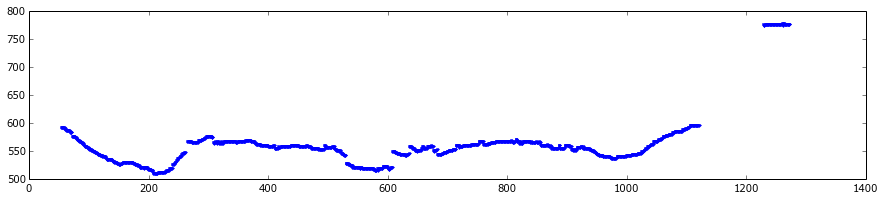

In [6]:
# Compute peak detection

peaks = image_stripe.argmax(axis=1)

# Show peak detection

pylab.rcParams['figure.figsize'] = (15, 3)
pylab.ylim([500,800])
    
plt.plot(peaks, '.')
plt.show()

### Center of mass
This method consist of computing the centroid of intensity for each row.

$$
\forall \: j \: \in  \: H :\:\:\:
cm_j = {\frac{\displaystyle\sum_{i}^{w} v_j · i}{\displaystyle\sum_{i}^{w} v_j}}
\: \Leftrightarrow \:
{\displaystyle\sum_{i}^{w} v_j} > 0 
$$

Time: 0:00:00.013856


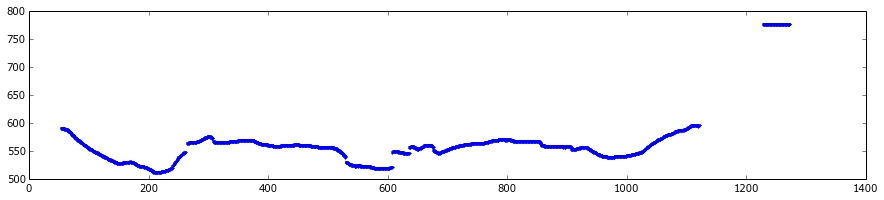

In [7]:
# Compute weight matrix

h, w = image_stripe.shape
weight_matrix = np.array((np.matrix(np.linspace(0, w - 1, w)).T * np.matrix(np.ones(h))).T)

# Compute center of mass

begin()

s = image_stripe.sum(axis=1)
v = np.where(s > 0)[0]
u = (weight_matrix * image_stripe).sum(axis=1)[v] / s[v]

end()

# Show center of mass

pylab.rcParams['figure.figsize'] = (15, 3)
pylab.ylim([500,800])
    
plt.plot(v, u, '.')
plt.show()

### Segmented gaussian filter
Center of mass method has better accuracy than peak detection, but stripe is not smooth enough. To improve that, a gaussian filter for each segment of the stripe will be applied.

In [8]:
# Detect stripe segments

begin()

i = 0
seg = []
segments = [s[_r] for _r in np.ma.clump_unmasked(np.ma.masked_equal(s, 0))]

for segment in segments:
    j = len(segment)
    seg.append(u[i:i+j])
    i += j
    
end()

Time: 0:00:00.000712


Number of segments: 3


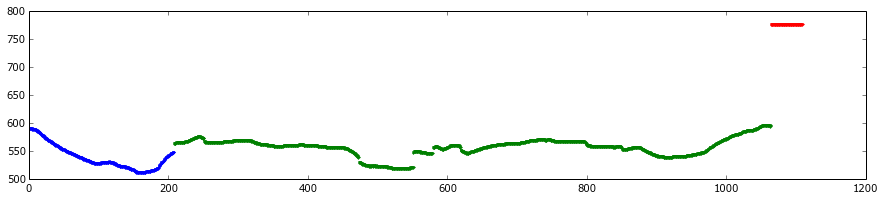

In [9]:
# Show segments

pylab.rcParams['figure.figsize'] = (15, 3)

from itertools import cycle
cycol = cycle('bgrcmk').next

i = 0
for segment in segments:
    j = len(segment)
    plt.plot(np.array(range(i,i+j)), u[i:i+j], '.', color=cycol())
    i += j

print('Number of segments: %s' % len(segments))
plt.show()

In [10]:
# Segmented gaussian filter

begin()

sigma = 2.0
f = np.array([])
for useg in seg:
    fseg = scipy.ndimage.gaussian_filter(useg, sigma=sigma)
    f = np.concatenate((f, fseg))

end()

Time: 0:00:00.000684


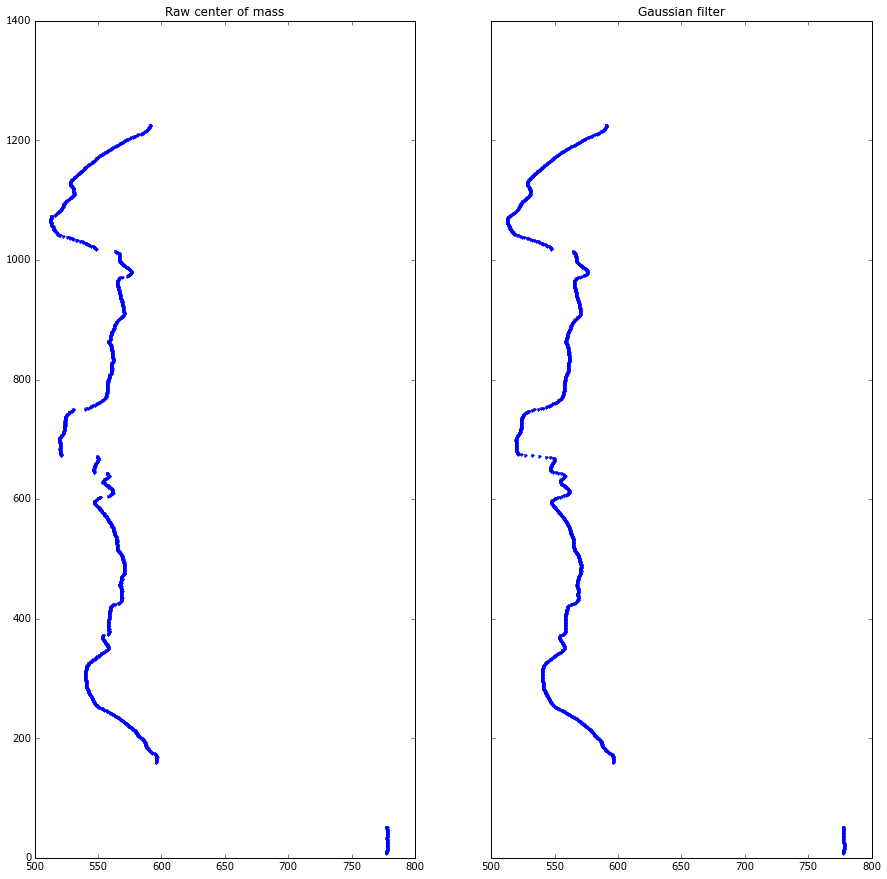

In [11]:
# Compare stripes

pylab.rcParams['figure.figsize'] = (15, 15)

_, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(u, h - v, '.')
ax1.set_title('Raw center of mass')
ax2.plot(f, h - v, '.')
ax2.set_title('Gaussian filter')
plt.show()

Total time: 0:00:00.034572


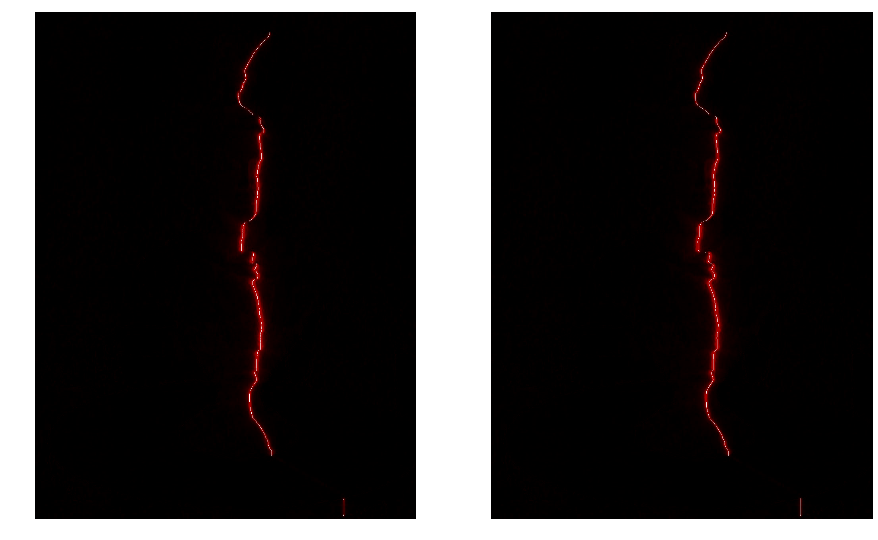

In [12]:
# Show images

image_line_cm = np.zeros_like(image_threshold)
image_line_gf = np.zeros_like(image_threshold)

image_line_cm[v, np.around(u).astype(int)] = 255
image_line_gf[v, np.around(f).astype(int)] = 255

image_cm = cv2.merge((cv2.add(image_diff_r, image_line_cm), image_line_cm, image_line_cm))
image_gf = cv2.merge((cv2.add(image_diff_r, image_line_gf), image_line_gf, image_line_gf))

print('Total time: %s' % total_time)

plot_images((image_cm, image_gf))

# References
* http://docs.opencv.org/doc/tutorials/imgproc/threshold/threshold.html